
# Simple introduction to networkx graph analysis
taken from https://www.programmersought.com/article/60151050844/

For graph theory, everyone knows more or less, and readers of mathematics or computer-related majors may be more aware of it. An image in graph theory is a graph composed of a number of given points and lines connecting two points. Such images are usually used to describe a certain relationship between certain things, and points are used to represent things. The connection line between the two represents a certain relationship between the two, and is widely used in the Internet and communication industries. Graph analysis is not a new branch in the field of data science, nor is it the preferred method of choice for data scientists. However, graph theory can do some crazy things. Some classic use cases include fraud detection, recommendation or social network analysis. The following figure is a non-classical use case in NLP - dealing with topic extraction.

# Fraud detection use case
Suppose now that you have a customer database and want to know how they are connected to each other. In particular, you know that some customers involve complex fraud structures, but visualizing data at the individual level does not lead to fraud evidence, and fraudsters look like other regular customers.
Simply look at the raw data and handle the connection between users to display more information. In particular, for a typical machine learning-based scoring model, these features are not considered risk, but these features that are not considered risky may become risk characteristics in a graph-based scoring model.

Example: Three people with the same phone number are connected to other people with the same email address, which is not normal and may be at risk. The phone number itself has little value and does not provide any information (so even the best deep learning model can't get any value information from it), but the individual is connected via the same phone number or email address, which may be A risk.

# Set up data, clean up, and create charts


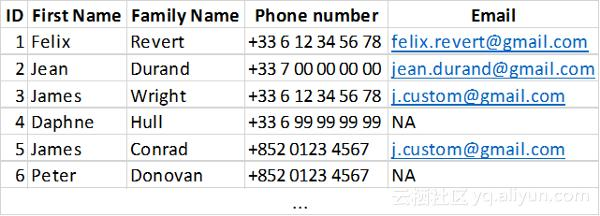

# Data creation

In [1]:
import pandas as pd

df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'First Name':['Felix', 'Jean', 'James', 'Daphne', 'James', 'Peter'], 
                   'Family Name': ['Revert', 'Durand', 'Wright', 'Hull', 'Conrad', 'Donovan'],
                   'Phone number': ['+33 6 12 34 56 78', '+33 7 00 00 00 00', '+33 6 12 34 56 78', '+33 6 99 99 99 99', '+852 0123 4567', '+852 0123 4567'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})


# G.add_nodes_from(df.ID.unique().tolist(), label='user')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  import sys


# Data preparation

### Phone numbers

In [2]:
column_edge = 'Phone number'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

# To create connections between people who have the same number,
# join data with itself on the 'ID' column.
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

In [3]:
data_to_merge

,ID,Phone number,ID_2
0,1,+33 6 12 34 56 78,1
1,1,+33 6 12 34 56 78,3
2,3,+33 6 12 34 56 78,1
3,3,+33 6 12 34 56 78,3
4,2,+33 7 00 00 00 00,2
5,4,+33 6 99 99 99 99,4
6,5,+852 0123 4567,5
7,5,+852 0123 4567,6
8,6,+852 0123 4567,5
9,6,+852 0123 4567,6


In [4]:
# By joining the data with itself, people will have a connection with themselves.
# Remove self connections, to keep only connected people who are different.
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
# To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
# we force the first ID to be "lower" then ID_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [5]:
d

,ID,ID_2,Phone number
1,1,3,+33 6 12 34 56 78
7,5,6,+852 0123 4567


### Creation of the graph

In [6]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

In [7]:
G.nodes()

NodeView((1, 3, 5, 6, 2, 4))

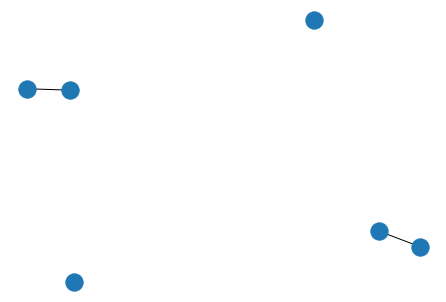

In [8]:
nx.draw(G)

### Emails

In [ ]:
column_edge = 'Email'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [ ]:
d

,ID,ID_2,Email
3,3,5,j.custom@gmail.com


In [ ]:
# Create the connections in the graph
links_attributes = {tuple(row[[column_ID, column_ID+"_2"]]): {column_edge: row[column_edge]} for i,row in d.iterrows()}

G.add_edges_from(links_attributes) # create the connection, without attribute. Check it with G.get_edge_data(3,5)
nx.set_edge_attributes(G=G, values=links_attributes) # adds the attribute. Check it with G.get_edge_data(3,5)

# Graph analysis

### Drawing graphs

In [ ]:
%matplotlib inline

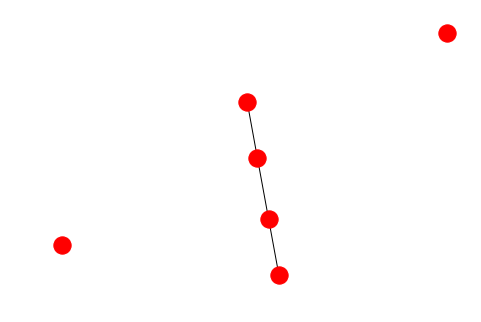

In [ ]:
nx.draw(G)

In [ ]:
{row[column_ID]:row['First Name'] +' '+ row['Family Name'] for i,row in df.iterrows()}

{1: 'Felix Revert',
 2: 'Jean Durand',
 3: 'James Wright',
 4: 'Daphne Hull',
 5: 'James Conrad',
 6: 'Peter Donovan'}

In [ ]:
nx.set_node_attributes(G, {row[column_ID]:{'Name': row['First Name'] +' '+ row['Family Name']} for i,row in df.iterrows()})

In [ ]:
EDGE_SIZE = {
    'Phone number': 2,
    'Email': 1,
}

EDGE_COLOR = {
    'Phone number': 'purple',
    'Email': 'red',
}

def clean_edge(edge):
    s.edge[edge[0], edge[1]].values()

def c_(list_edges): return [a for a in list_edges if a in list(EDGE_COLOR.keys())]
    
# For nx.Graph()
def edge_sizes(s): return [EDGE_SIZE[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one size
def edge_colors(s): return [EDGE_COLOR[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one color

# For nx.MultiDiGraph()
# def edge_sizes(s): return [EDGE_SIZE[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one size
# def edge_colors(s): return [EDGE_COLOR[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one color

def draw(s):
    pos = nx.spring_layout(s, scale=0.5)
    node_labels = dict((n,d['Name']) for n,d in s.nodes(data=True))
#     labels = {**node_labels, **edge_labels}
    nx.draw(s, pos=pos, width=edge_sizes(s), edge_color=edge_colors(s), alpha=0.8, arrows=False, node_color='lightgrey', node_size=400,
            labels=node_labels, 
            font_color='black', font_size=8, font_weight='bold',
           )
    edge_labels = dict(((u,v),list(d.values())[0]) for u,v,d in G.edges(data=True))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)

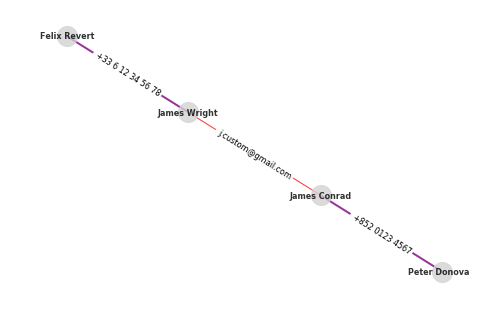

In [ ]:
draw(nx.ego_graph(G=G, n=1, radius=3))

### Automated detection of strange patterns

In [ ]:
degrees = list(nx.degree(G))

In [ ]:
pd.DataFrame([list(d) for d in degrees], columns=['ID', 'degree']).sort_values('degree', ascending=False).head(5)

,ID,degree
1,3,2
2,5,2
0,1,1
3,6,1
4,2,0


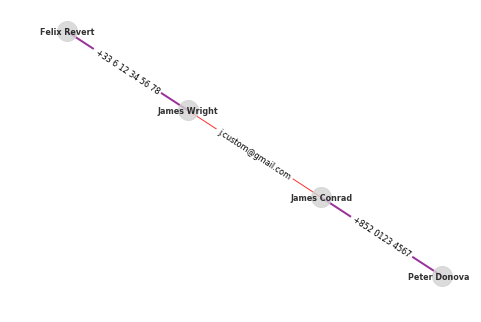

In [ ]:
draw(nx.ego_graph(G=G, n=3, radius=2))